<h1 style="color: #116805;">00 | Libraries</h1>

In [ ]:
# Libraries
import numpy as np
import pandas as pd
import warnings

# Viz
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

# Stats
import scipy.stats as st
from scipy.stats import chi2_contingency # Chi-square test
from scipy.stats.contingency import association # Cramér's V
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
import pingouin as pg # ANOVA test
from pingouin import welch_anova # Welch's ANOVA

# ML
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler # Standardization
from sklearn.preprocessing import MinMaxScaler # Normalization


# ⚙️ Settings
pd.set_option('display.max_columns', None) # display all columns
pd.set_option('display.max_rows', None) # display all rows
warnings.filterwarnings('ignore') # ignore warnings

<h1 style="color: #116805;">Functions</h1>

In [3]:
# Dealing with outliers excluding target column
def outliers_dealing_target(df, target_column): 
    """
    Automatically removes outliers based on Q1, Q3
    Excludes the target column
    """
    for column in df.select_dtypes(include=[np.number]):
        if column == target_column: #skip the target column
            continue
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

Rating Range https://www.fifplay.com/encyclopedia/player-attributes/

In [4]:
# Function to add Rating Range Colum 
def categorize_column(df, column_name):
    # Define the range for bins
    bins = [-float('inf'), 39, 49, 69, 79, 89, 99]
    
    # Label each bin
    labels = ['Very Poor', 'Poor', 'Fair', 'Good', 'Very Good', 'Excellent']

    # Create a new column with the bin labels
    new_column_name = f'{column_name}_rating'
    df[new_column_name] = pd.cut(
        df[column_name], 
        bins=bins, 
        labels=labels, 
        include_lowest=True
    )
    return df

<h1 style="color: #116805;">01 | Data Extraction</h1>

In [5]:
data = pd.read_csv('fifa_23_players_data.csv')
data.head(5)

,Known As,Full Name,Overall,Potential,Value(in Euro),Positions Played,Best Position,Nationality,Image Link,Age,Height(in cm),Weight(in kg),TotalStats,BaseStats,Club Name,Wage(in Euro),Release Clause,Club Position,Contract Until,Club Jersey Number,Joined On,On Loan,Preferred Foot,Weak Foot Rating,Skill Moves,International Reputation,National Team Name,National Team Image Link,National Team Position,National Team Jersey Number,Attacking Work Rate,Defensive Work Rate,Pace Total,Shooting Total,Passing Total,Dribbling Total,Defending Total,Physicality Total,Crossing,Finishing,Heading Accuracy,Short Passing,Volleys,Dribbling,Curve,Freekick Accuracy,LongPassing,BallControl,Acceleration,Sprint Speed,Agility,Reactions,Balance,Shot Power,Jumping,Stamina,Strength,Long Shots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,Standing Tackle,Sliding Tackle,Goalkeeper Diving,Goalkeeper Handling,GoalkeeperKicking,Goalkeeper Positioning,Goalkeeper Reflexes,ST Rating,LW Rating,LF Rating,CF Rating,RF Rating,RW Rating,CAM Rating,LM Rating,CM Rating,RM Rating,LWB Rating,CDM Rating,RWB Rating,LB Rating,CB Rating,RB Rating,GK Rating
0,L. Messi,Lionel Messi,91,91,54000000,RW,CAM,Argentina,https://cdn.sofifa.net/players/158/023/23_60.png,35,169,67,2190,452,Paris Saint-Germain,195000,99900000,RW,2023,30,2021,-,Left,4,4,5,Argentina,https://cdn.sofifa.net/flags/ar.png,RW,10,Low,Low,81,89,90,94,34,64,84,90,70,91,88,95,93,93,90,93,87,76,91,92,95,86,68,70,68,91,44,40,93,94,75,96,20,35,24,6,11,15,14,8,90,90,91,91,91,90,91,91,88,91,67,66,67,62,53,62,22
1,K. Benzema,Karim Benzema,91,91,64000000,"CF,ST",CF,France,https://cdn.sofifa.net/players/165/153/23_60.png,34,185,81,2147,455,Real Madrid CF,450000,131199999,CF,2023,9,2009,-,Right,4,4,4,France,https://cdn.sofifa.net/flags/fr.png,ST,19,Medium,Medium,80,88,83,87,39,78,75,92,90,89,88,87,82,73,76,91,79,80,78,92,72,87,79,82,82,80,63,39,92,89,84,90,43,24,18,13,11,5,5,7,91,87,89,89,89,87,91,89,84,89,67,67,67,63,58,63,21
2,R. Lewandowski,Robert Lewandowski,91,91,84000000,ST,ST,Poland,https://cdn.sofifa.net/players/188/545/23_60.png,33,185,81,2205,458,FC Barcelona,420000,172200000,ST,2025,9,2022,-,Right,4,4,5,Poland,https://cdn.sofifa.net/flags/pl.png,ST,9,High,Medium,75,91,79,86,44,83,71,94,91,84,89,85,79,85,70,89,76,75,77,93,82,91,85,76,87,84,81,49,94,81,90,88,35,42,19,15,6,12,8,10,91,85,88,88,88,85,88,86,83,86,67,69,67,64,63,64,22
3,K. De Bruyne,Kevin De Bruyne,91,91,107500000,"CM,CAM",CM,Belgium,https://cdn.sofifa.net/players/192/985/23_60.png,31,181,70,2303,483,Manchester City,350000,198900000,CM,2025,17,2015,-,Right,5,4,4,Belgium,https://cdn.sofifa.net/flags/be.png,RF,7,High,High,74,88,93,87,64,77,94,85,55,93,83,88,89,83,93,90,76,73,76,91,78,92,63,88,74,91,75,66,88,94,83,89,68,65,53,15,13,5,10,13,86,88,87,87,87,88,91,91,91,91,82,82,82,78,72,78,24
4,K. Mbappé,Kylian Mbappé,91,95,190500000,"ST,LW",ST,France,https://cdn.sofifa.net/players/231/747/23_60.png,23,182,73,2177,470,Paris Saint-Germain,230000,366700000,ST,2024,7,2018,-,Right,4,5,4,France,https://cdn.sofifa.net/flags/fr.png,ST,10,High,Low,97,89,80,92,36,76,78,93,72,85,83,93,80,69,71,91,97,97,93,93,81,88,77,87,76,82,64,38,92,83,80,88,26,34,32,13,5,7,11,6,92,90,90,90,90,90,92,92,84,92,70,66,70,66,57,66,21


<h2 style="color: #21bf0b;">Column standardization</h2>

In [6]:
data.columns = [column.lower().replace(" ", "_") for column in data.columns]

<h2 style="color: #21bf0b;">Copy as best practices</h2>

In [7]:
df = data.copy()

<h2 style="color: #21bf0b;">Exploring the Data</h2>

 [Dataset](https://www.kaggle.com/datasets/sanjeetsinghnaik/fifa-23-players-dataset)
_____________
**First impression:**    

This dataset contains information regarding 18,539 players and their statistics thoroughout one year, displayed among 89 columns. 71 integers & 18 objects.

**Goal:**    

The **goal** of this project is:
- To identify patterns around the value of the players.
- Are there differences in the value of the player according to the position they play in?
- Can you predict the value according to some of the features within the dataset? What are the best features for it? For this we will be using **value(in_euro)** as the **target**.
_____________
**Positions**: 
- **CB** (Center Back), **CM** (Central Midfielder), **ST** (Striker), **GK** (Goalkeeper), **CDM** (Central Defensive Midfielder), **LB** (Left Back), **RB** (Right Back), **RM** (Right Midfielder), **LM** (Left Midfielder), **CAM** (Central Attacking Midfielder), **RW** (Right Winger), **LW** (Left Winger), **LWB** (Left Wing Back), **RWB** (Right Wing Back), **RF** (Right Forward), **LF** (Left Forward), **CF** (Center Forward)

In [ ]:
# dtypes()
# value_counts()
# isnull().sum()
# duplicated().sum()
# describe
# info()
# df1.eq(" ").sum()


<h1 style="color: #116805;">02 | Data Cleaning</h1>

<h2 style="color: #21bf0b;">Dropping columns</h2>

The columns selected to dropped are based on features as:
- player identifiers
- situations specific to players' situation within the club
- information regarding national details
- too in-depth information from the players (there are aggregated stats based on them)

In [8]:
cols = ['image_link', 'national_team_image_link',
                      'contract_until', 'club_jersey_number',
                      'joined_on', 'on_loan', 'national_team_name', 'national_team_position',
                      'national_team_jersey_number', 'st_rating', 'lw_rating', 'cf_rating',
                      'rf_rating', 'rw_rating', 'cam_rating', 'lm_rating', 'cm_rating',
                      'rm_rating', 'lwb_rating', 'cdm_rating', 'rwb_rating', 'lb_rating',
                      'cb_rating', 'rb_rating', 'gk_rating',
                      'totalstats','basestats', 'crossing', 'finishing', 'volleys', 'dribbling', 
                      'curve', 'freekick_accuracy', 'longpassing', 'ballcontrol', 
                      'acceleration', 'sprint_speed', 'agility', 'reactions', 
                      'balance', 'shot_power', 'jumping', 'stamina', 'strength', 
                      'long_shots', 'aggression', 'interceptions', 'positioning', 
                      'vision', 'penalties', 'composure', 'marking', 'standing_tackle', 
                      'sliding_tackle', 'positions_played', 'club_position',
                      'weak_foot_rating', 'skill_moves', 'international_reputation', 'age', 'height(in_cm)', 'weight(in_kg)', 'lf_rating']

df1 = df.drop(columns=cols)

In [ ]:
# clean csv file for Tableau purpose
# df2_CSV = df3.to_csv('fifa_23_tableau.csv')
# csv containing the clean csv, with the added features 

<h2 style="color: #21bf0b;">Checking Duplicates</h2>

In [10]:
df1.duplicated().sum()

0

In [9]:
df1.drop_duplicates(inplace=True)

<h2 style="color: #21bf0b;">Other</h2>

In [ ]:
# club_name --> free agent 90 (value_counts)
# club_position --> '-' 90 (value_counts)--> how to delete these rows

In [ ]:
# Cleaning club_name column - creates 90 '-' entries
elem = 'Free agent'
elem1 = '9 de Octubre'
filter = df1['club_name'].str.contains(elem) | df1['club_name'].str.contains(elem1)
df3 = df1[~filter]

In [11]:
# columns to categorize within range defined in 'categorize_column' function
cols_to_categorize = ['pace_total', 'shooting_total', 'passing_total', 'dribbling_total',
                    'defending_total', 'physicality_total', 'heading_accuracy', 'short_passing', 'overall', 'potential']

for column in cols_to_categorize:
    df3 = categorize_column(df3, column)

In [12]:
# Conditions for the bins
conditions = [
    df3['value(in_euro)'] < 500000, 
    (df3['value(in_euro)'] >= 500000) & (df3['value(in_euro)'] <= 975000),
    df3['value(in_euro)'] > 975000 
]

# Label each bin
labels = ['<500000', '500000-975000', '>975000']

# Create a new column with the bin labels
df3['value_category'] = pd.cut(
    df3['value(in_euro)'], 
    bins=[-float('inf'), 500000, 975000, float('inf')],  # Define the range for bins
    labels=labels, 
    include_lowest=True
)

<h2 style="color: #21bf0b;">Moving our target to the right</h2>

In [13]:
target = df3.pop('value(in_euro)')
df3['value(in_euro)'] = target

<h1 style="color: #116805;">03 | EDA (Exploratory Data Analysis)</h1>

<h2 style="color: #21bf0b;">Selecting numerical and categorical</h2>

In [14]:
cat = df3.select_dtypes(exclude="number")
num = df3.select_dtypes(include="number")

# Being specific
cat_from_num = num.loc[:, num.nunique() < 20] # how does .loc work Vs .iloc
cat2 = pd.concat([cat, cat_from_num], axis=1)

num2 = num.drop(columns=cat_from_num.columns)

In [114]:
# Find the first player with the maximum value in each position
max_value_players = df3.groupby('best_position').apply(lambda x: x.loc[x['value(in_euro)'].idxmax()])
# max_value_players

<h2 style="color: #21bf0b;">About the categorical columns</h2>

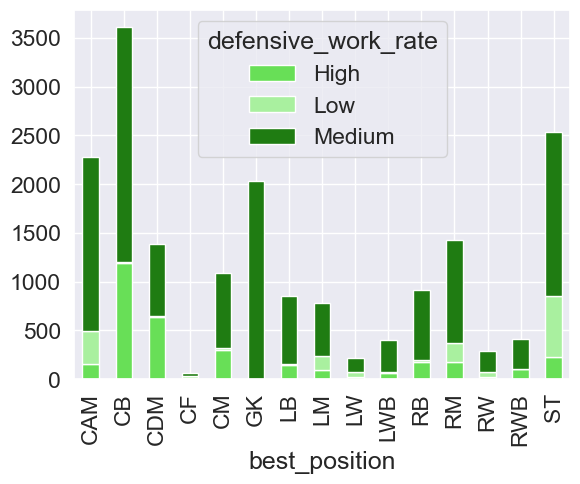

In [67]:
crosstab_result = pd.crosstab(df3['best_position'], df3['defensive_work_rate'])

# Plotting a stacked bar chart for the 'crosstab_result' data
crosstab_result.plot(kind='bar',
                    stacked=True,
                    color = ['#68df57', '#a9f09f', '#1f7c12'])
plt.show()

In [ ]:
# Frequency Table
frequency_table = cat.overall_rating.value_counts()

# Propotion 
proportion_table = cat.overall_rating.value_counts(normalize=True) # If we do normalize=True, we get a proportion table

# create df
df_concat = pd.concat([frequency_table, proportion_table], axis=1)

# name columns
df_concat.columns = ['absolute_frequency', 'proportion']
round(df_concat, 2)

,absolute_frequency,proportion
overall_rating,,
Fair,13162,0.72
Good,4553,0.25
Very Good,493,0.03
Poor,94,0.01
Excellent,10,0.00
Very Poor,0,0.00


In [19]:
# Frequency Table
frequency_table = cat.defensive_work_rate.value_counts()

# Propotion 
proportion_table = cat.defensive_work_rate.value_counts(normalize=True) # If we do normalize=True, we get a proportion table

# create df
df_concat = pd.concat([frequency_table, proportion_table], axis=1)

# name columns
df_concat.columns = ['absolute_frequency', 'proportion']
round(df_concat, 2)

,absolute_frequency,proportion
defensive_work_rate,,
Medium,13461,0.74
High,3320,0.18
Low,1531,0.08


- **absolute_frequency** gives the count, while **proportion** provides the % representation of each category within the dataset. Helps identifying dominant and minority categories

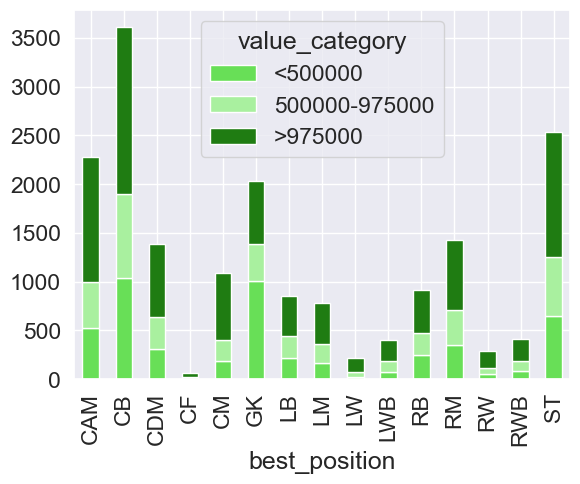

In [68]:
crosstab_result = pd.crosstab(df3['best_position'], df3['value_category'])

# Plotting a stacked bar chart for the 'crosstab_result' data
crosstab_result.plot(kind='bar',
                    stacked=True,
                    color = ['#68df57', '#a9f09f', '#1f7c12'])
plt.show()

<h2 style="color: #21bf0b;">Chi-Square</h2>

Tests the independence of two categorical variables by comparing observed frequencies to expected frequencies.

- The chi-square test is a statistical test used to **determine whether there is a significant association between two categorical variables**. 
- Interpretation: if p-value < 0.05, this suggests that there is a significant association between the categorical variables. P-value >= 0.05, indicates that there is not enough evidence to conclude a significant association between the variables. 

In [21]:
alpha = 0.05

<h5 style="color: #21bf0b;">Are players more expensive depending on their position?</h5>

**Hypothesis Testing**
- H0: Value in EUR does not depend on the position they play in
- H1: Value in EUR depends on the position they play in 

In [115]:
crosstab_result = pd.crosstab(df3['best_position'], df3['value_category'])
#crosstab_result

###
# Plotting a stacked bar chart for the 'crosstab_result' data
# crosstab_result.plot(kind='bar', stacked=True)
# plt.show()

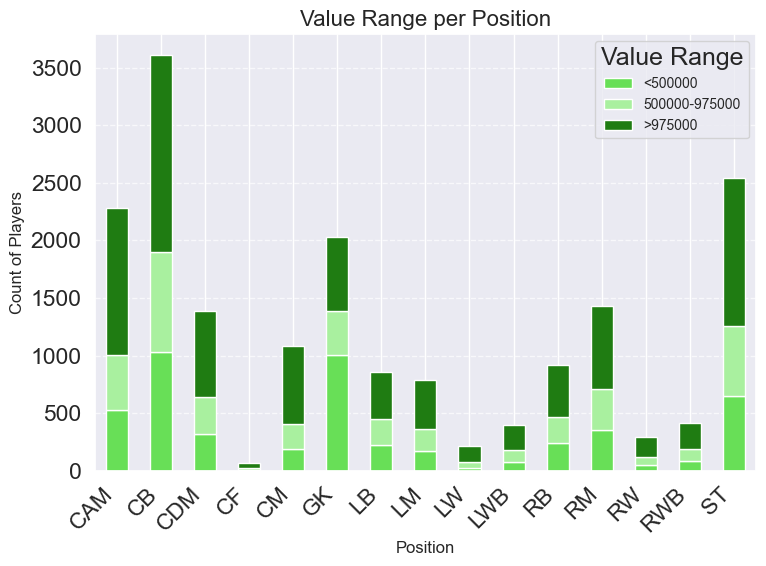

In [117]:
crosstab_result.plot(kind='bar',
                    stacked=True,
                    color = ['#68df57', '#a9f09f', '#1f7c12'],
                    figsize=(8,6)
                    )
plt.title('Value Range per Position', fontsize=16)  
plt.xlabel('Position', fontsize=12) 
plt.ylabel('Count of Players', fontsize=12)  
plt.xticks(rotation=45, ha='right')  
plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.legend(title='Value Range', fontsize=10)
plt.tight_layout()

plt.show()

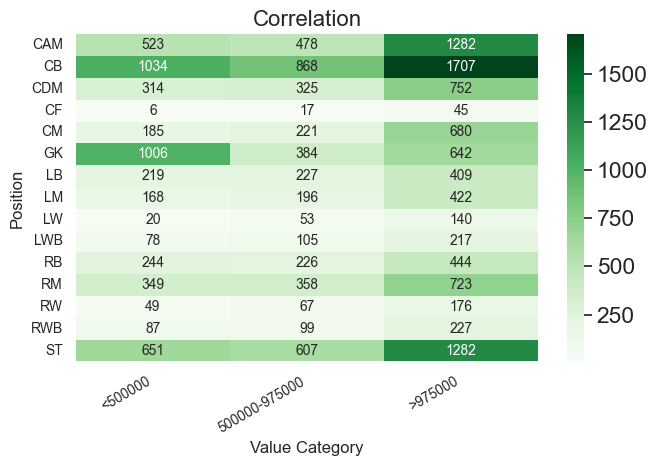

In [69]:
plt.figure(figsize=(7, 5))
sns.heatmap(crosstab_result, annot=True, fmt='d', cmap='Greens', annot_kws={"size": 10})
 
plt.title('Correlation', fontsize=16) 
plt.xlabel('Value Category', fontsize=12) 
plt.ylabel('Position', fontsize=12)  
plt.xticks(rotation=30, fontsize=10, ha='right')
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.tight_layout()
plt.show()

In [25]:
# Chi-square test for 'best_position' and 'value_category'
chi2_stats, chi2_pvalue, _, _ = chi2_contingency(crosstab_result)
print(f"Chi-square p-value: {chi2_pvalue:.170f}")

if chi2_pvalue < alpha:
    print("There is an association between the categorical variables")
else:
    print("There is no assoociation between the categorical variables")

Chi-square p-value: 0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000108552276544770863425669
There is an association between the categorical variables


<h2 style="color: #21bf0b;">Cramér's V</h2>

While the Chi-square test informs us about the independence of two categorical variables, Cramér's V measures the strength of the association between them. 

- Cramer's V is a measure of association used to **quantify the strength of the relationship between categorical variables**. 
- Interpretation: Cramer's V ranges from 0 to 1, where **0 indicates no association, and 1 represents a perfect association between the variables**. A higher value of Cramer's V indicates a stronger relationship between the categorical variables.

In [27]:
# Computing the association between variables in 'crosstab_result' using the "cramer" method
association(crosstab_result, method='cramer')

0.14660070429859948

**crosstab_result = pd.crosstab(df3['best_position'], df3['value_category'])**
- **Chi-square:** p_value < alpha -- Reject H0, so there is a relationship btw these 2 variables
- **Cramér's:** 0.14 -- low relationship btw the categorical variables

<h2 style="color: #21bf0b;">About the numerical columns</h2>

In [28]:
df3.describe().T

,count,mean,std,min,25%,50%,75%,max
overall,18312.0,6.577845e+01,6.773871e+00,47.0,62.0,66.0,70.0,91.0
potential,18312.0,7.096358e+01,6.177117e+00,48.0,67.0,71.0,75.0,95.0
wage(in_euro),18312.0,8.784114e+03,1.949831e+04,500.0,1000.0,3000.0,8000.0,450000.0
release_clause,18312.0,5.043147e+06,1.472467e+07,0.0,675000.0,1500000.0,3300000.0,366700000.0
pace_total,18312.0,6.795959e+01,1.065387e+01,28.0,62.0,68.0,75.0,97.0
shooting_total,18312.0,5.371336e+01,1.361176e+01,16.0,44.0,56.0,64.0,92.0
passing_total,18312.0,5.795620e+01,9.709091e+00,25.0,52.0,58.0,64.0,93.0
dribbling_total,18312.0,6.304423e+01,9.325837e+00,28.0,58.0,64.0,69.0,94.0
defending_total,18312.0,5.017240e+01,1.636743e+01,15.0,35.0,54.0,63.0,91.0
physicality_total,18312.0,6.472630e+01,9.573010e+00,30.0,58.0,66.0,72.0,91.0


**Insights Summary for 'value(in_euro)'**
- The average (mean) is `2,858,729.46 €` 
- The median is `975,000 €`. As its lower than the mean it suggests a skew in the distribution towards higher prices.
- The standard deviation is `7,664,872.44 €`, indicating that the value of the players vary significanlty from the average
- The IQR (interquartile range) --> **Q1** = `500,000 €`, **Q2** = `975,000 €` & **Q3** = `2,000,000 €`

In [29]:
df4 = max_value_players[['known_as', 'release_clause', 'value(in_euro)']]
df4['difference'] = max_value_players['release_clause'] - max_value_players['value(in_euro)'] 
df4

,known_as,release_clause,value(in_euro),difference
best_position,,,,
CAM,P. Foden,224500000,109500000,115000000
CB,Rúben Dias,206900000,107500000,99400000
CDM,J. Kimmich,182000000,105500000,76500000
CF,K. Benzema,131199999,64000000,67199999
CM,F. de Jong,247600000,116500000,131100000
GK,G. Donnarumma,199200000,103500000,95700000
LB,João Cancelo,152600000,82500000,70100000
LM,S. Mané,164200000,99500000,64700000
LW,Vinícius Jr.,245300000,109000000,136300000


In [118]:
# highest 15 players: value(in_euro)
top_25_players = df3.nlargest(25, 'value(in_euro)')
# top_25_players.head(5)

<h2 style="color: #21bf0b;">Aggregations</h2>

In [31]:
df_agg = top_25_players.groupby('club_name').agg({'value(in_euro)': 'mean'}).reset_index()

<h2 style="color: #21bf0b;">Correlations</h2>

In [119]:
# num2.corrwith(df3['value(in_euro)']).sort_values(ascending=False)

In [34]:
# Pearson Correlation value and release clause - Pearson & Spearman
pearson = df3['value(in_euro)'].corr(df3['release_clause'])
spearman = df3['value(in_euro)'].corr(df3['release_clause'], method='spearman')

print(f"Pearson Correlation: {pearson:.2f}")
print(f"Spearman Correlation: {spearman:.2f}")

Pearson Correlation: 0.98
Spearman Correlation: 0.81


**Insights: Correlation between Value in Eur and Release Clause**
- **Pearson** = 0.98, suggesting a very strong positive linear relationship between the two variables. As the Value increases, the release clause increases. 
- **Spearman** = 0.81, suggesting a strong positive monotonic relationship between the two variables, meaning that when one increases, the other one tends to increase too but not at a constant rate.

In [35]:
# Pearson Correlation value and release clause - Pearson & Spearman
pearson = df3['value(in_euro)'].corr(df3['overall'])
spearman = df3['value(in_euro)'].corr(df3['overall'], method='spearman')

print(f"Pearson Correlation: {pearson:.2f}")
print(f"Spearman Correlation: {spearman:.2f}")


Pearson Correlation: 0.56
Spearman Correlation: 0.86


**Insights: Correlation between Value in Eur and Overall Rating**
- **Pearson** = 0.56, suggesting a positive linear relationship between the two variables. As the Value increases, the release clause increases. 
- **Spearman** = 0.86, suggesting a strong positive monotonic relationship between the two variables, meaning that when one increases, the other one tends to increase too but not at a constant rate.

<h1 style="color: #116805;">04 | Hypothesis Testing</h1>

<h2 style="color: #21bf0b;">One-way ANOVA</h2>

In [36]:
# Extract value (in EUR) from the different positions
df_CB = df3[df3['best_position'] == 'CB']['value(in_euro)']
df_ST = df3[df3['best_position'] == 'ST']['value(in_euro)']
df_CAM = df3[df3['best_position'] == 'CAM']['value(in_euro)']
df_GK = df3[df3['best_position'] == 'GK']['value(in_euro)']
df_RM = df3[df3['best_position'] == 'RM']['value(in_euro)']
df_CDM = df3[df3['best_position'] == 'CDM']['value(in_euro)']
df_CM = df3[df3['best_position'] == 'CM']['value(in_euro)']
df_RB = df3[df3['best_position'] == 'RB']['value(in_euro)']
df_LB = df3[df3['best_position'] == 'LB']['value(in_euro)']
df_LM = df3[df3['best_position'] == 'LM']['value(in_euro)']
df_RWB = df3[df3['best_position'] == 'RWB']['value(in_euro)']
df_LWB = df3[df3['best_position'] == 'LWB']['value(in_euro)']
df_RW = df3[df3['best_position'] == 'RW']['value(in_euro)']
df_LW = df3[df3['best_position'] == 'LW']['value(in_euro)']
df_CF = df3[df3['best_position'] == 'CF']['value(in_euro)']

In [37]:
# Perform One-Way ANOVA Test
f_stat, p_value = st.f_oneway(df_CB, df_ST, df_CAM, df_GK, df_RM, df_CDM, df_CM, df_RB, df_LB, df_LM, df_RWB, df_LWB, df_RW, df_LW, df_CF)
print(f"F-Statistics : {f_stat:.2f}")
print(f"P-Value : {p_value:.40f}")
print()

# Significance level
alpha = 0.05

# Decision
if p_value < alpha:
    print("Reject the Null Hypothesis: Significant result.")
else:
    print("Fail to Reject the Null Hypothesis: Not a significant result.")

F-Statistics : 15.56
P-Value : 0.0000000000000000000000000000000000000222

Reject the Null Hypothesis: Significant result.


**ETA-Squared**
- Using ANOVA pinguin's function we have to (1) give the dv (depending variable) which is the scael variable, (2) include the variable with the categories and (3) if you want to see the results in a df, we include 'detailed=True'.

In [40]:
eta = pg.anova(dv='value(in_euro)', between='best_position', data=df3)
eta

,Source,ddof1,ddof2,F,p-unc,np2
0,best_position,14,18297,15.55605,2.223687e-38,0.011763


- ddof1 = 14: This is the number of groups (levels of best_position) minus 1.
- ddof2 = 18297: This is the total sample size minus the number of groups.
- F: The F-statistic tests whether there are significant differences between group means. A larger F-value indicates greater variation between group means relative to within-group variation.
- p-unic: value associated with the F-test. This one is very small, meaning it is much smaller than any conventional significance level (0.05)
- np2: partial eta-quared, which measures the effect size. This one suggests a small effect size, therefore, while 'best_position' has a statistically significant effect, the magnitude of the effect is small. 

- CCL: ANOVA test shows there are statistically significant differences in value € accross the different positions players play. 

In [42]:
aov= welch_anova(dv='value(in_euro)', between='best_position', data=df3)
aov

,Source,ddof1,ddof2,F,p-unc,np2
0,best_position,14,2197.859381,10.443761,2.918978e-23,0.011763


<h1 style="color: #116805;">05 | Data Processing</h1>

<h2 style="color: #21bf0b;">Checking Distributions</h2>

In [56]:
# Move the target to the right
target = num2.pop('value(in_euro)')
num2['value(in_euro)'] = target

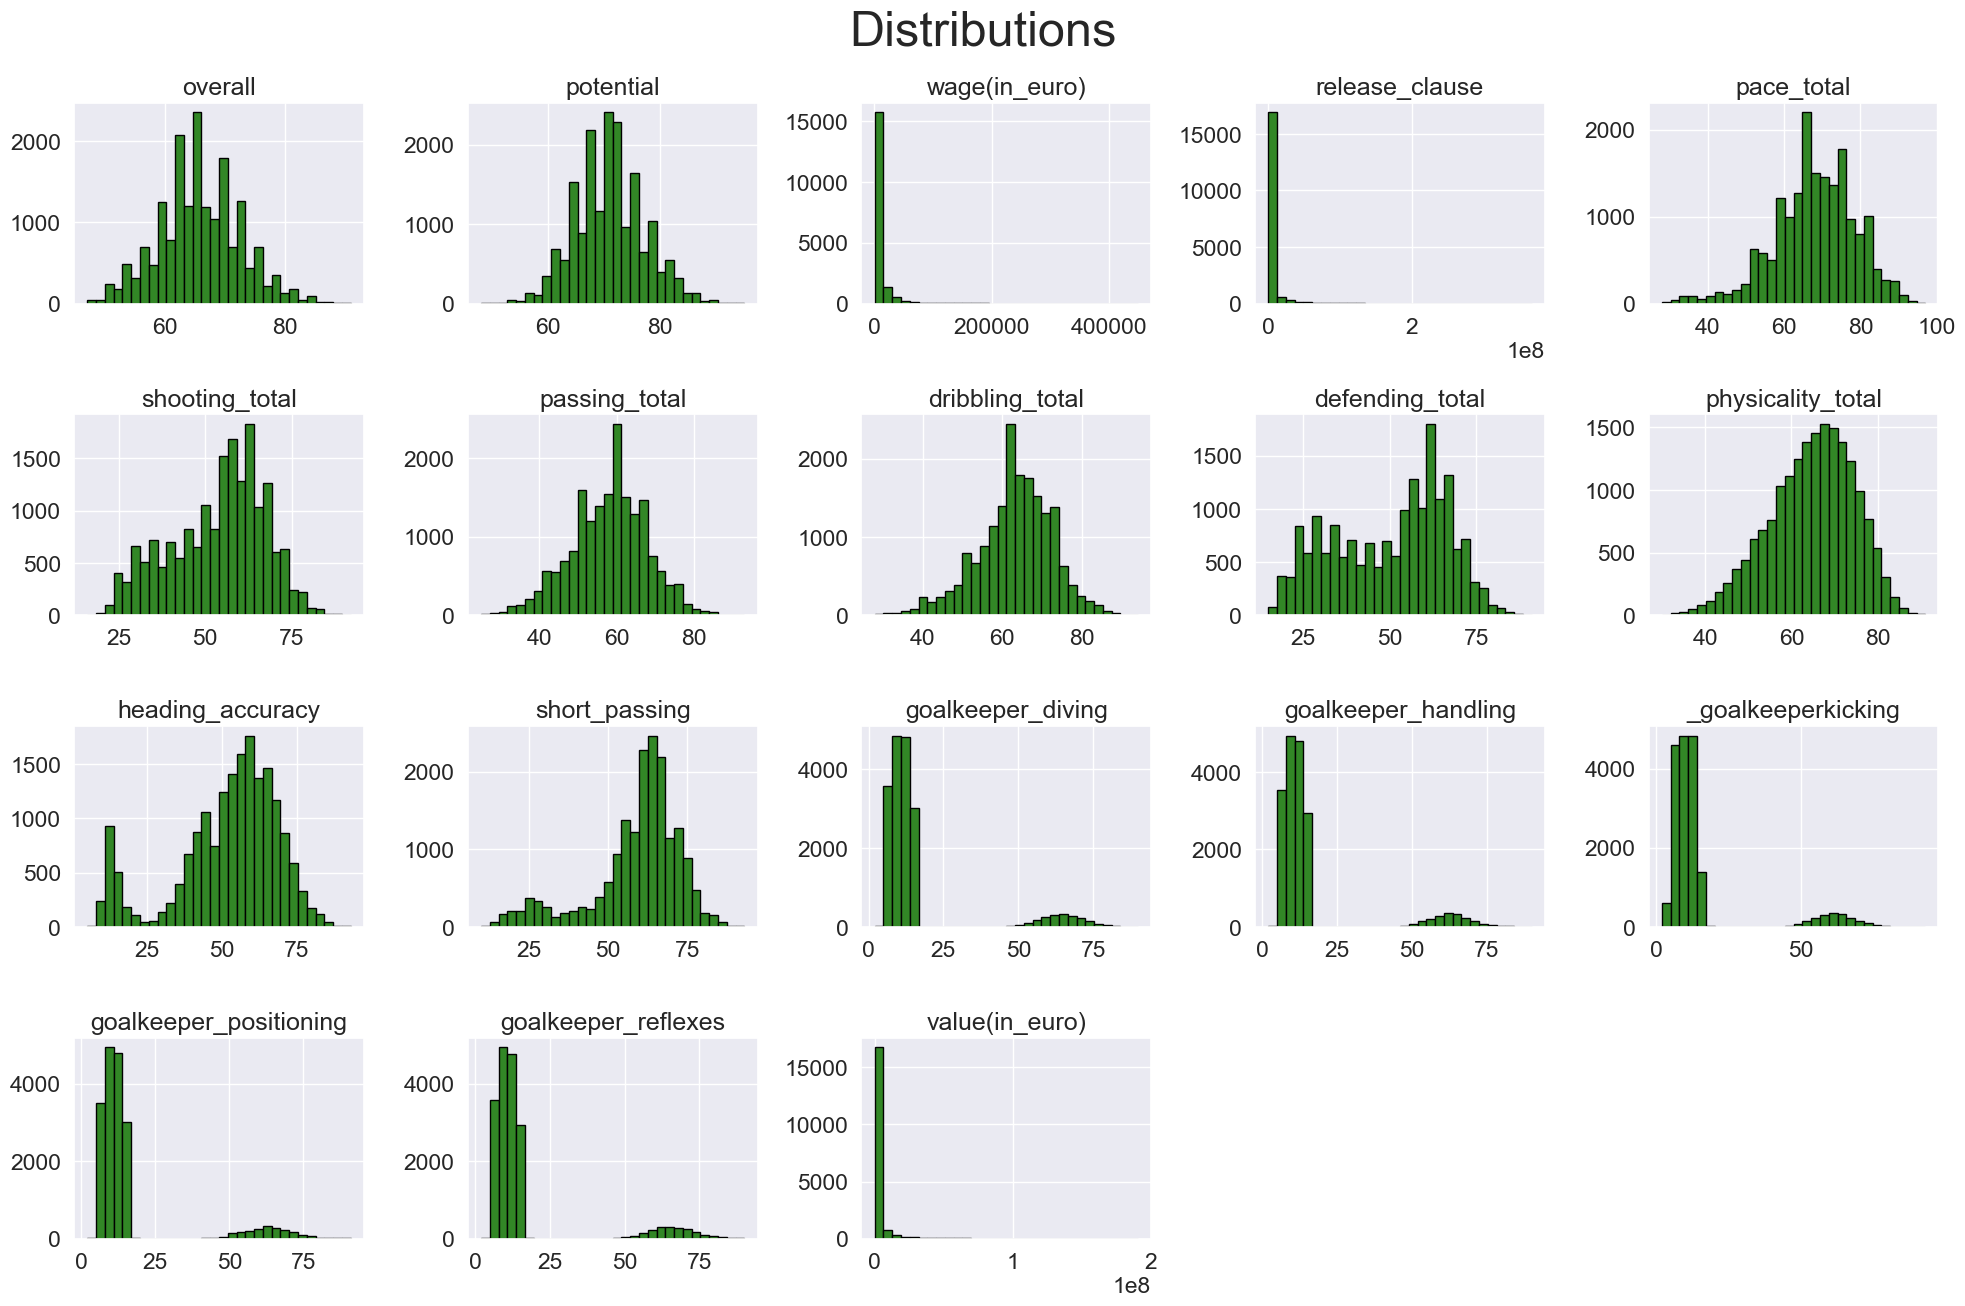

In [72]:
color = '#328726'

# grid size
nrows, ncols = 5, 5  # adjust for your number of features

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 16))

axes = axes.flatten()

# Plot each numerical feature
for i, ax in enumerate(axes):
    if i >= len(num2.columns):
        ax.set_visible(False)  # hide unesed plots
        continue
    ax.hist(num2.iloc[:, i], bins=30, color=color, edgecolor='black')
    ax.set_title(num2.columns[i])

# Add a central title
fig.suptitle("Distributions", fontsize=35)

plt.tight_layout()
plt.show()

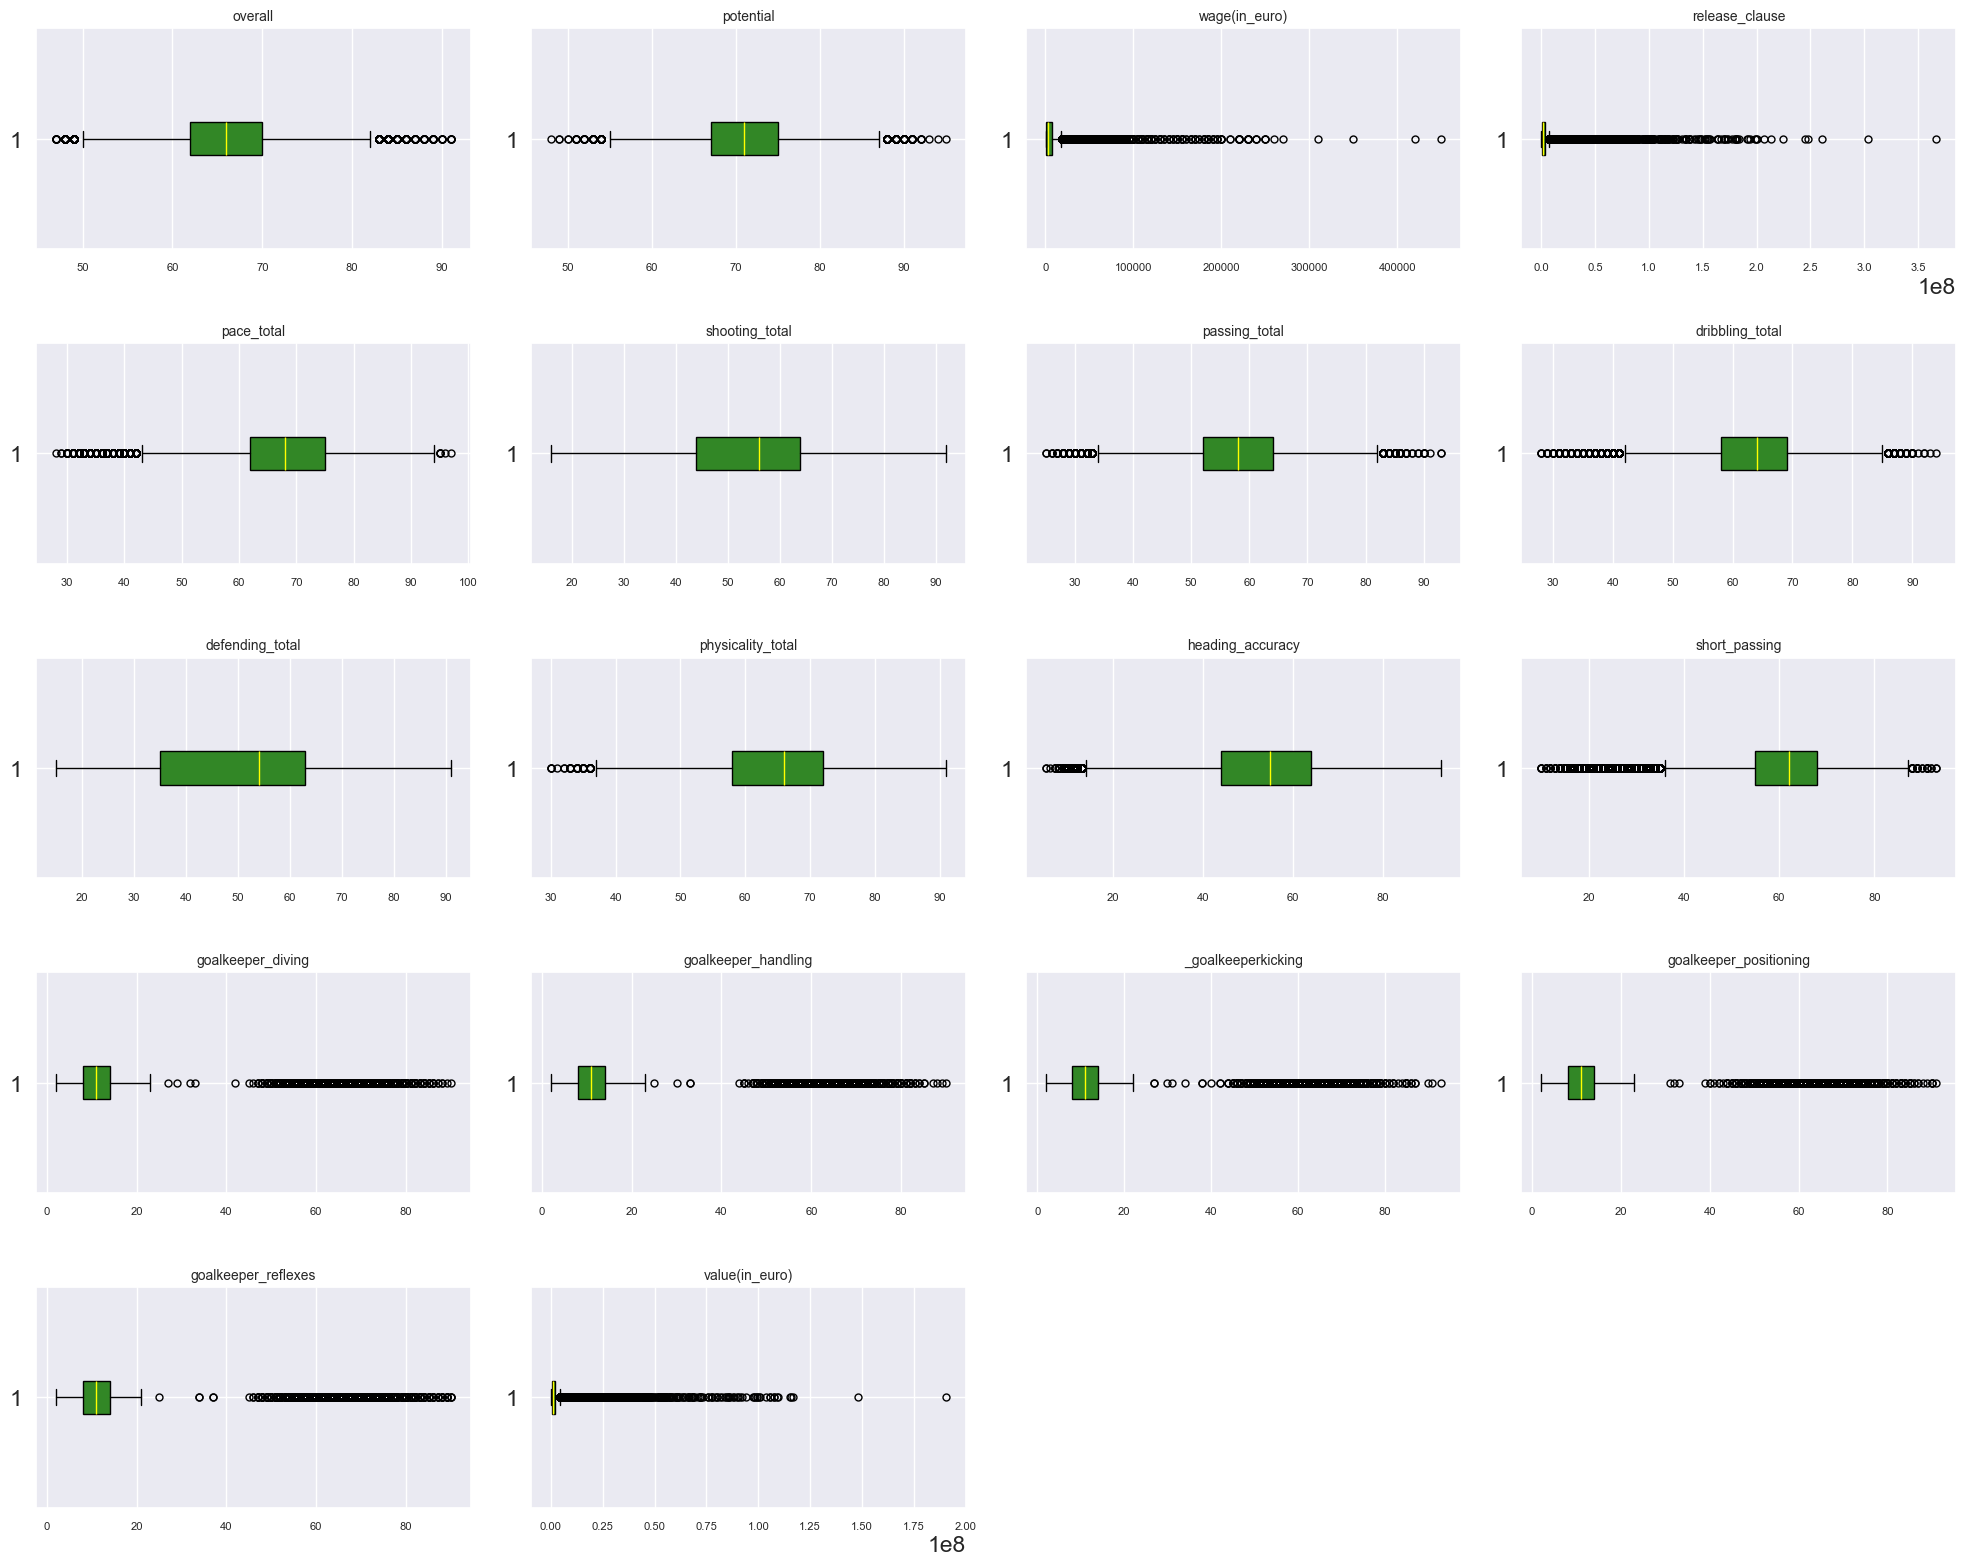

In [73]:
color = '#328726'

# grid size
nrows, ncols = 5, 4 

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 16))

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= len(num2.columns):
        ax.set_visible(False)
        continue
    ax.boxplot(num2.iloc[:, i].dropna(), vert=False, patch_artist=True, 
               boxprops=dict(facecolor=color, color='black'), 
               medianprops=dict(color='yellow'), whiskerprops=dict(color='black'), 
               capprops=dict(color='black'), flierprops=dict(marker='o', color='red', markersize=5))
    ax.set_title(num2.columns[i], fontsize=10)
    ax.tick_params(axis='x', labelsize=8)
    

plt.tight_layout()
plt.show()

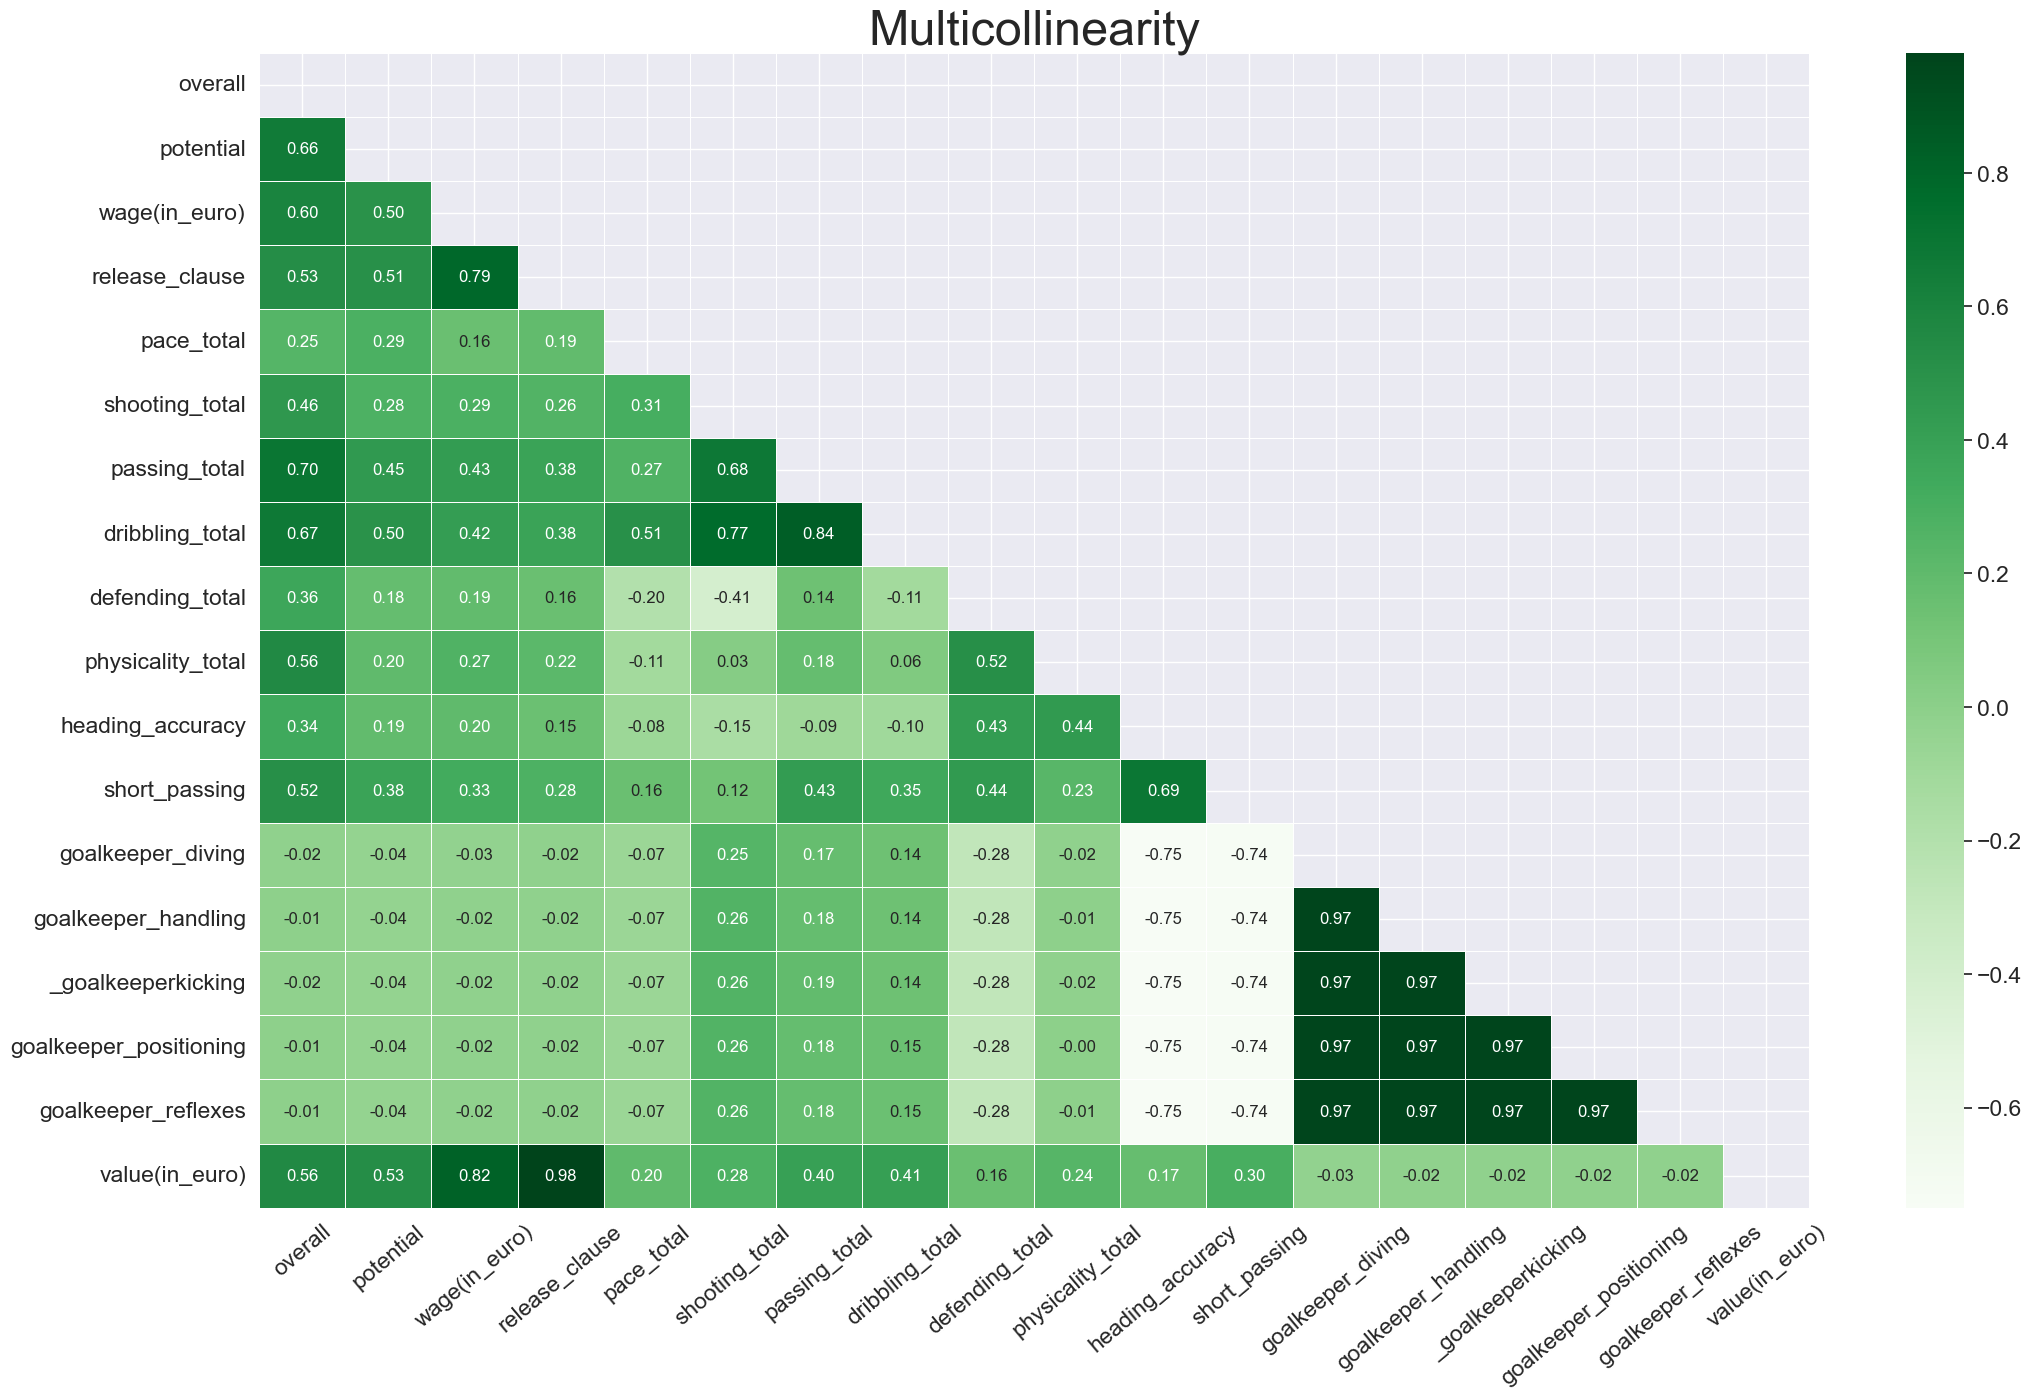

In [74]:
num_corr = round(num2.corr(), 2)

# Correlation Matrix-Heatmap Plot
mask = np.zeros_like(num_corr)
mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix
f, ax = plt.subplots(figsize=(25, 15))
sns.set(font_scale=1.5) # increase font size
ax = sns.heatmap(num_corr, mask=mask, annot=True, annot_kws={"size": 12}, linewidths=.5, cmap="Greens", fmt=".2f", ax=ax) # round to 2 decimal places
ax.set_title("Multicollinearity", fontsize=35) # add title
plt.xticks(rotation=40)
plt.show()

<h2 style="color: #21bf0b;">Selecting Features</h2>

In [43]:
# Target Variables
col_to_drop = ['release_clause']
num3 = num2.drop(columns=col_to_drop)

In [44]:
# Handling the outliers (!except on the target column !) and run again model to see difference
no_out_num2 = outliers_dealing_target(num2, target_column='value(in_euro)')
no_out_num3 = outliers_dealing_target(num3, target_column='value(in_euro)')

In [120]:
print(num2.shape)
print(num3.shape)
print(no_out_num2.shape)
print(no_out_num3.shape)

(18312, 18)
(18312, 17)
(11924, 18)
(12789, 17)


<h1 style="color: #116805;">06 | Modeling</h1>

<h2 style="color: #21bf0b;">X-Y Split</h2>

In [108]:
X = num3.drop("value(in_euro)", axis=1) # drop the target for the 'X'
y = num3["value(in_euro)"] # put the target in 'y'

<h2 style="color: #21bf0b;">Train-Test Split</h2>

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

<h2 style="color: #21bf0b;">Linear Regression</h2>

In [110]:
# Train the model
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [111]:
#Model validation - predictions on the test dataset
predictions = model.predict(X_test)

#Metric
r_1 = r2_score(y_test, predictions)
RMSE_1 = mean_squared_error(y_test, predictions, squared=False)
MSE_1 = mean_squared_error(y_test, predictions)
MAE_1 = mean_absolute_error(y_test, predictions)

#Printing the results
print("R2 = ", round(r_1, 4))
print("RMSE = ", round(RMSE_1, 4))
print("MSE =  ", round(MSE_1, 4)) 
print("MAE = ", round(MAE_1, 4))

R2 =  0.712
RMSE =  4207798.9663
MSE =   17705572141008.742
MAE =  1820045.1848


<h2 style="color: #21bf0b;">Lasso</h2>
Prevent overfitting

In [172]:
lasso = Lasso()
lasso.fit(X_train, y_train)

Lasso()

In [173]:
#Model validation
predictions_lasso = lasso.predict(X_test)

#Metric
r2_3_3 = r2_score(y_test, predictions_lasso)
RMSE_3_3 = mean_squared_error(y_test, predictions_lasso, squared=False)
MSE_3_3 = mean_squared_error(y_test, predictions_lasso)
MAE_3_3 = mean_absolute_error(y_test, predictions_lasso)

#Printing the results
print("R2 = ", round(r2_3_3, 4))
print("RMSE = ", round(RMSE_3_3, 4))
print("MSE = ", round(MSE_3_3, 4))
print("MAE = ", round(MAE_3_3, 4))

R2 =  0.4586
RMSE =  1350795.9829
MSE =  1824649787298.0193
MAE =  553947.7785


<h2 style="color: #21bf0b;">Standardization with StandardScaler</h2>

We choose **Standarization** because the distributions of the features we are selecing are consistent, they vary within a range of 0-100, meaning there are not many outliers. 

In [86]:
# Standarization of data
scaler = StandardScaler()

# Train the model
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Fit the model
model.fit(X_train_scaled, y_train)

# Predictions
predictions2 = model.predict(X_test_scaled)

#Metric
r2_3 = r2_score(y_test, predictions2)
RMSE_3 = mean_squared_error(y_test, predictions2, squared=False)
MSE_3 = mean_squared_error(y_test, predictions2)
MAE_3 = mean_absolute_error(y_test, predictions2)

#Printing the results
print("R2 = ", round(r2_3, 4))
print("RMSE = ", round(RMSE_3, 4))
print("MSE =  ", round(MSE_3, 4)) 
print("MAE = ", round(MAE_3, 4))

R2 =  0.9682
RMSE =  1398996.0641
MSE =   1957189987234.141
MAE =  536389.2277


<h2 style="color: #21bf0b;">Normalization with MinMaxScaler</h2>

In [57]:
scaler = MinMaxScaler()

In [ ]:
# Train the model
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#Fit the model
model.fit(X_train_scaled, y_train)

# Predictions
predictions4 = model.predict(X_test_scaled)

#Metric
r2_3 = r2_score(y_test, predictions4)
RMSE_3 = mean_squared_error(y_test, predictions4, squared=False)
MSE_3 = mean_squared_error(y_test, predictions4)
MAE_3 = mean_absolute_error(y_test, predictions4)

#Printing the results
print("R2 = ", round(r2_3, 4))
print("RMSE = ", round(RMSE_3, 4))
print("MSE =  ", round(MSE_3, 4)) 
print("MAE = ", round(MAE_3, 4))

R2 =  0.712
RMSE =  4207798.9663
MSE =   17705572141008.797
MAE =  1820045.1848


<h2 style="color: #21bf0b;">Log Transform</h2>

In [174]:
X_train_log = np.log1p(X_train)  # np.log1p is useful to handle zero values in your data
X_test_log = np.log1p(X_test)

model.fit(X_train_log, y_train)
predictions3 = model.predict(X_test_log)

In [175]:
r2_3_7 = r2_score(y_test, predictions3)
RMSE_3_7 = mean_squared_error(y_test, predictions3, squared=False)
MSE_3_7 = mean_squared_error(y_test, predictions3)
MAE_3_7 = mean_absolute_error(y_test, predictions3)

#Printing the results
print("R2 = ", round(r2_3_7, 4))
print("RMSE = ", round(RMSE_3_7, 4))
print("MSE = ", round(MSE_3_7, 4))
print("MAE = ", round(MAE_3_7, 4))

R2 =  0.4179
RMSE =  1400589.4373
MSE =  1961650771930.6611
MAE =  583077.951


<h1 style="color: #116805;">07 | Reporting</h1>

<h2 style="color: #21bf0b;">num2</h2>

Features: 'overall', 'potential', 'wage(in_euro)', 'release_clause', 'pace_total',
       'shooting_total', 'passing_total', 'dribbling_total', 'defending_total',
       'physicality_total', 'heading_accuracy', 'short_passing',
       'goalkeeper_diving', 'goalkeeper_handling', '_goalkeeperkicking',
       'goalkeeper_positioning', 'goalkeeper_reflexes', 'value(in_euro)'

In [112]:
# Make a dataframe to compare num2
eval_df = pd.DataFrame({"actual":y_test,"predictions":predictions})

# Difference 
eval_df["difference"] = abs(eval_df["actual"]-eval_df["predictions"])
eval_df.head()

,actual,predictions,difference
17136,375000,1.117040e+06,7.420397e+05
7107,1200000,1.948951e+06,7.489508e+05
8884,850000,1.203687e+05,7.296313e+05
15183,350000,-1.523544e+05,5.023544e+05
15351,350000,-8.029600e+05,1.152960e+06


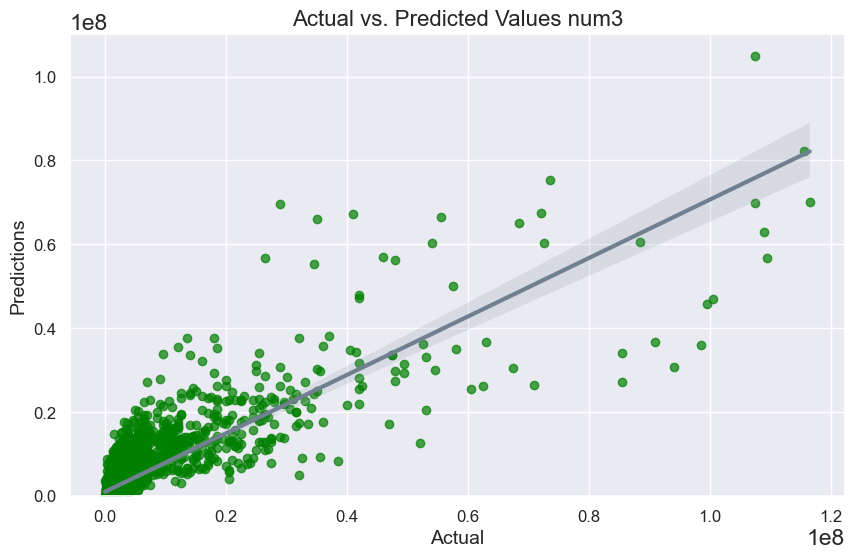

In [113]:
# num2
scatter_color = "green"
line_color = "slategray"

plt.figure(figsize=(10, 6))

sns.regplot(x='actual', y='predictions', data=eval_df,
            scatter_kws={"color": scatter_color, "alpha": 0.7},
            line_kws={"color": line_color, "linewidth": 3})

plt.ylim(bottom=0)
plt.title('Actual vs. Predicted Values num3', fontsize=16)
plt.xlabel('Actual', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [87]:
# Make a dataframe to compare num2 after Standardization
eval_df = pd.DataFrame({"actual":y_test,"predictions":predictions2})

# Difference 
eval_df["difference"] = abs(eval_df["actual"]-eval_df["predictions"])
eval_df.head()

,actual,predictions,difference
17136,375000,6.498671e+05,274867.092193
7107,1200000,1.337862e+06,137862.112493
8884,850000,7.257268e+05,124273.203098
15183,350000,3.635051e+05,13505.109138
15351,350000,1.271357e+05,222864.333916


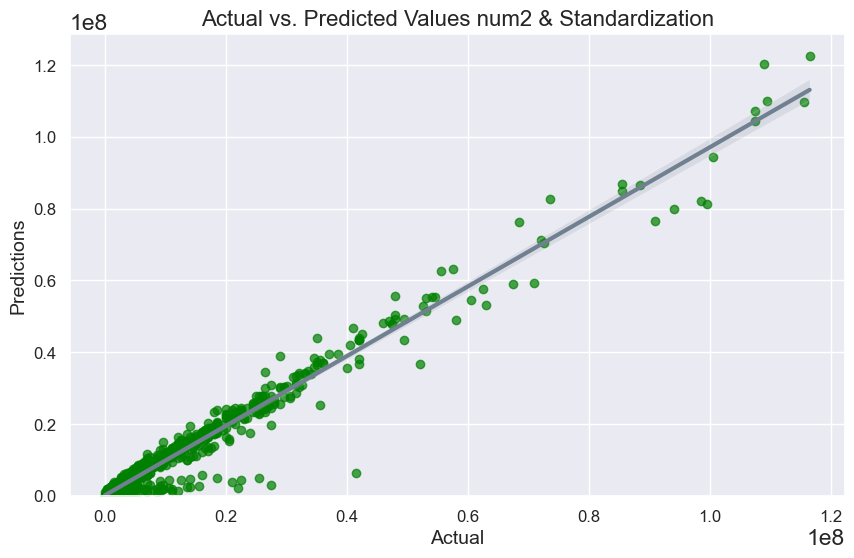

In [88]:
# num2 & Standardization
scatter_color = "green"
line_color = "slategray"

plt.figure(figsize=(10, 6))

sns.regplot(x='actual', y='predictions', data=eval_df,
            scatter_kws={"color": scatter_color, "alpha": 0.7},
            line_kws={"color": line_color, "linewidth": 3})

plt.ylim(bottom=0)
plt.title('Actual vs. Predicted Values num2 & Standardization', fontsize=16)
plt.xlabel('Actual', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

<h2 style="color: #21bf0b;">num3</h2>
Features: 'overall', 'potential', 'wage(in_euro)', 'pace_total', 'shooting_total',
       'passing_total', 'dribbling_total', 'defending_total',
       'physicality_total', 'heading_accuracy', 'short_passing',
       'goalkeeper_diving', 'goalkeeper_handling', '_goalkeeperkicking',
       'goalkeeper_positioning', 'goalkeeper_reflexes', 'value(in_euro)'

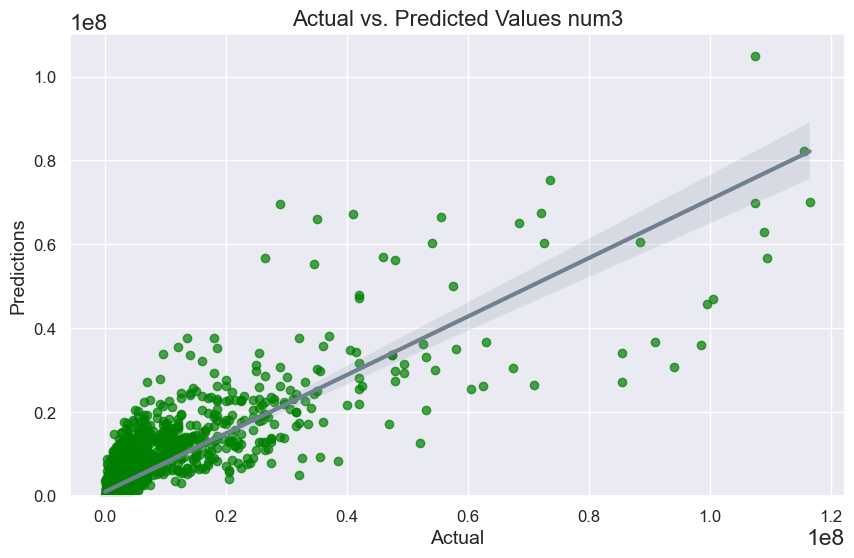

In [121]:
# Make a dataframe to compare num3
eval_df = pd.DataFrame({"actual":y_test,"predictions":predictions})

# Difference 
eval_df["difference"] = abs(eval_df["actual"]-eval_df["predictions"])
eval_df.head()

# num2
scatter_color = "green"
line_color = "slategray"

plt.figure(figsize=(10, 6))

sns.regplot(x='actual', y='predictions', data=eval_df,
            scatter_kws={"color": scatter_color, "alpha": 0.7},
            line_kws={"color": line_color, "linewidth": 3})

plt.ylim(bottom=0)
plt.title('Actual vs. Predicted Values num3', fontsize=16)
plt.xlabel('Actual', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

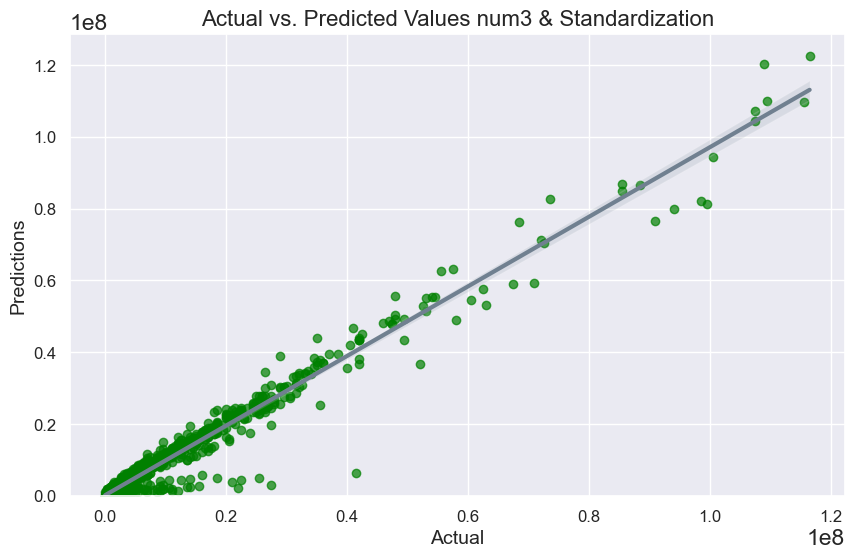

In [123]:
# Make a dataframe to compare num3 & Standardization
eval_df = pd.DataFrame({"actual":y_test,"predictions":predictions2})

# Difference 
eval_df["difference"] = abs(eval_df["actual"]-eval_df["predictions"])
eval_df.head()

# num2
scatter_color = "green"
line_color = "slategray"

plt.figure(figsize=(10, 6))

sns.regplot(x='actual', y='predictions', data=eval_df,
            scatter_kws={"color": scatter_color, "alpha": 0.7},
            line_kws={"color": line_color, "linewidth": 3})

plt.ylim(bottom=0)
plt.title('Actual vs. Predicted Values num3 & Standardization', fontsize=16)
plt.xlabel('Actual', fontsize=14)
plt.ylabel('Predictions', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

<h1 style="color: #116805;">Vizz Purposes</h1>

In [ ]:
ML_results = [
    {'Scenario': 'num2 - Linear Regression',
    "R²": 0.9682,
    "RMSE": 1398996.0641,
    "MSE": 1957189987236.3604,
    "MAE": 536389.2277
},
{'Scenario': 'num2 - Linear Regression StandardScaler',
    "R²": 0.9682,
    "RMSE": 1398996.0641,
    "MSE": 1957189987234.141,
    "MAE": 536389.2277
},
{'Scenario': 'num2 - Linear Regression Log Transform',
    "R²": 0.3581,
    "RMSE": 6282461.3364,
    "MSE": 39469320442959.445,
    "MAE": 3095983.1045
},
{'Scenario': 'num2 - Lasso',
    "R²": 0.9682,
    "RMSE": 1398995.9914,
    "MSE": 1957189783974.146,
    "MAE": 536389.0519
},
{'Scenario': 'num2 - Lasso StandardScaler',
    "R²": 0.9682,
    "RMSE": 1398996.0641,
    "MSE": 1957189987234.141,
    "MAE": 536389.2277
},
{'Scenario': 'num2 - Lasso Log Transform',
    "R²": 0.3581,
    "RMSE": 6282461.3364,
    "MSE": 39469320442959.445,
    "MAE": 3095983.1045
},
{'Scenario': 'num2 no outliers - Linear Regression',
    "R²": 0.5978,
    "RMSE": 529328.6248,
    "MSE": 280188793010.4734,
    "MAE": 221002.5797
},
{'Scenario': 'num2 no outliers - Linear Regression StandardScaler',
    "R²": 0.5978,
    "RMSE": 529328.6248,
    "MSE": 280188793009.6344,
    "MAE": 221002.5797
},
{'Scenario': 'num2 no outliers - Linear Regression Log Transform',
    "R²": 0.5808,
    "RMSE": 540394.2053,
    "MSE": 292025897136.7426,
    "MAE": 263427.2506
},
{'Scenario': 'num2 no outliers - Lasso',
    "R²": 0.5978,
    "RMSE": 529328.7329,
    "MSE": 280188907503.7796,
    "MAE": 221002.4523
},
{'Scenario': 'num2 no outliers- Lasso StandardScaler',
    "R²": 0.5978,
    "RMSE": 529328.6248,
    "MSE": 280188793009.6344,
    "MAE": 221002.5797
},
{'Scenario': 'num2 no outliers - Lasso Log Transform',
    "R²": 0.5808,
    "RMSE": 540394.2053,
    "MSE": 292025897136.7426,
    "MAE": 263427.2506
},
{'Scenario': 'num3 - Linear Regression',
    "R²": 0.712,
    "RMSE": 4207798.9663,
    "MSE": 17705572141008.742,
    "MAE": 1820045.1848
},
{'Scenario': 'num3 - Linear Regression StandardScaler',
    "R²": 0.712,
    "RMSE": 4207798.9663,
    "MSE": 17705572141008.793,
    "MAE": 1820045.1848
},
{'Scenario': 'num3 - Linear Regression Log Transform',
    "R²": 0.3445,
    "RMSE": 6348434.7035,
    "MSE": 40302623185231.76,
    "MAE": 3103465.9501
},
{'Scenario': 'num3 - Lasso',
    "R²": 0.712,
    "RMSE": 4207798.9066,
    "MSE": 17705571638356.367,
    "MAE": 1820044.9695
},
{'Scenario': 'num3 - Lasso StandardScaler',
    "R²": 0.712,
    "RMSE": 4207798.9663,
    "MSE": 17705572141008.793,
    "MAE": 1820045.1848
},
{'Scenario': 'num3 - Lasso Log Transform',
    "R²": 0.3445,
    "RMSE": 6348434.7035,
    "MSE":40302623185231.76,
    "MAE": 3103465.9501,
}, 
{'Scenario': 'num3 no outliers - Linear Regression',
    "R²": 0.4586,
    "RMSE": 1350795.9484,
    "MSE": 1824649694181.024,
    "MAE": 553947.8683
},
{'Scenario': 'num3 no outliers - Linear Regression StandardScaler',
    "R²": 0.4586,
    "RMSE": 1350795.9484,
    "MSE": 1824649694181.018,
    "MAE": 553947.8683
},
{'Scenario': 'num3 no outliers - Linear Regression Log Transform',
    "R²": 0.4179,
    "RMSE": 1400589.4373,
    "MSE": 1961650771930.6611,
    "MAE": 583077.951
},  
{'Scenario': 'num3 no outliers - Lasso',
    "R²": 0.4586,
    "RMSE": 1350795.9829,
    "MSE": 1824649787298.0193,
    "MAE": 553947.7785
},
{'Scenario': 'num3 no outliers - Lasso StandardScaler',
    "R²": 0.4586,
    "RMSE": 1350795.9484,
    "MSE": 1824649694181.018,
    "MAE": 553947.8683
},
{'Scenario': 'num3 no outliers - Lasso Log Transform',
    "R²": 0.4179,
    "RMSE": 1400589.4373,
    "MSE": 1961650771930.6611,
    "MAE": 583077.951 
}]

LG_results_df = pd.DataFrame(ML_results)

LG_results_df.set_index('Scenario', inplace=True)

In [124]:
# LG_results_df

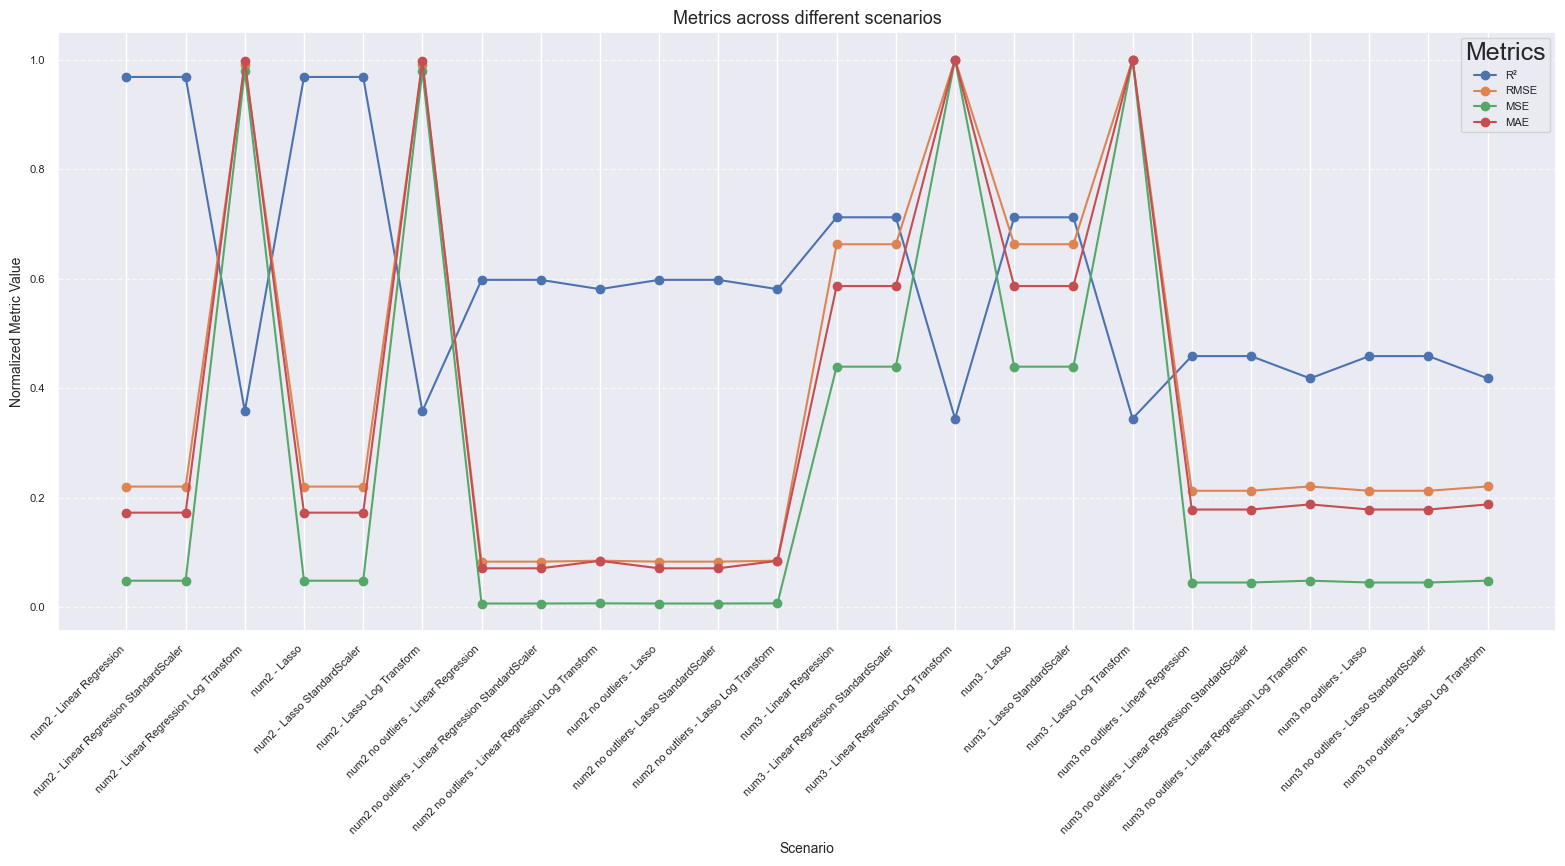

In [ ]:
# normalize the data
df_normalized = LG_results_df.copy()
for col in ["RMSE", "MSE", "MAE"]:
    df_normalized[col] = LG_results_df[col] / LG_results_df[col].max()

# Plot line graph
plt.figure(figsize=(16, 9))
for column in df_normalized.columns:
    plt.plot(df_normalized.index, df_normalized[column], marker='o', label=column)

#  titles and labels
plt.title("Metrics across different scenarios", fontsize=13)
plt.ylabel("Normalized Metric Value", fontsize=10)
plt.xlabel("Scenario", fontsize=10)
plt.xticks(fontsize=8, rotation=45, ha='right')
plt.yticks(fontsize=8)
plt.grid(axis='y', linestyle="--", alpha=0.7)
plt.legend(title="Metrics", fontsize=8)
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
ML_results3 = [
{'Scenario Num3': 'Linear Regression',
    "R²": 0.712,
    "RMSE": 4207798.9663,
    "MSE": 17705572141008.742,
    "MAE": 1820045.1848
},
{'Scenario Num3': 'Linear Regression StandardScaler',
    "R²": 0.712,
    "RMSE": 4207798.9663,
    "MSE": 17705572141008.793,
    "MAE": 1820045.1848
},
{'Scenario Num3': 'Linear Regression Log Transform',
    "R²": 0.3445,
    "RMSE": 6348434.7035,
    "MSE": 40302623185231.76,
    "MAE": 3103465.9501
},
{'Scenario Num3': 'Lasso',
    "R²": 0.712,
    "RMSE": 4207798.9066,
    "MSE": 17705571638356.367,
    "MAE": 1820044.9695
},
{'Scenario Num3': 'Lasso StandardScaler',
    "R²": 0.712,
    "RMSE": 4207798.9663,
    "MSE": 17705572141008.793,
    "MAE": 1820045.1848
},
{'Scenario Num3': 'Lasso Log Transform',
    "R²": 0.3445,
    "RMSE": 6348434.7035,
    "MSE":40302623185231.76,
    "MAE": 3103465.9501,
}]

LG_results_df3 = pd.DataFrame(ML_results3)

LG_results_df3.set_index('Scenario Num3', inplace=True)



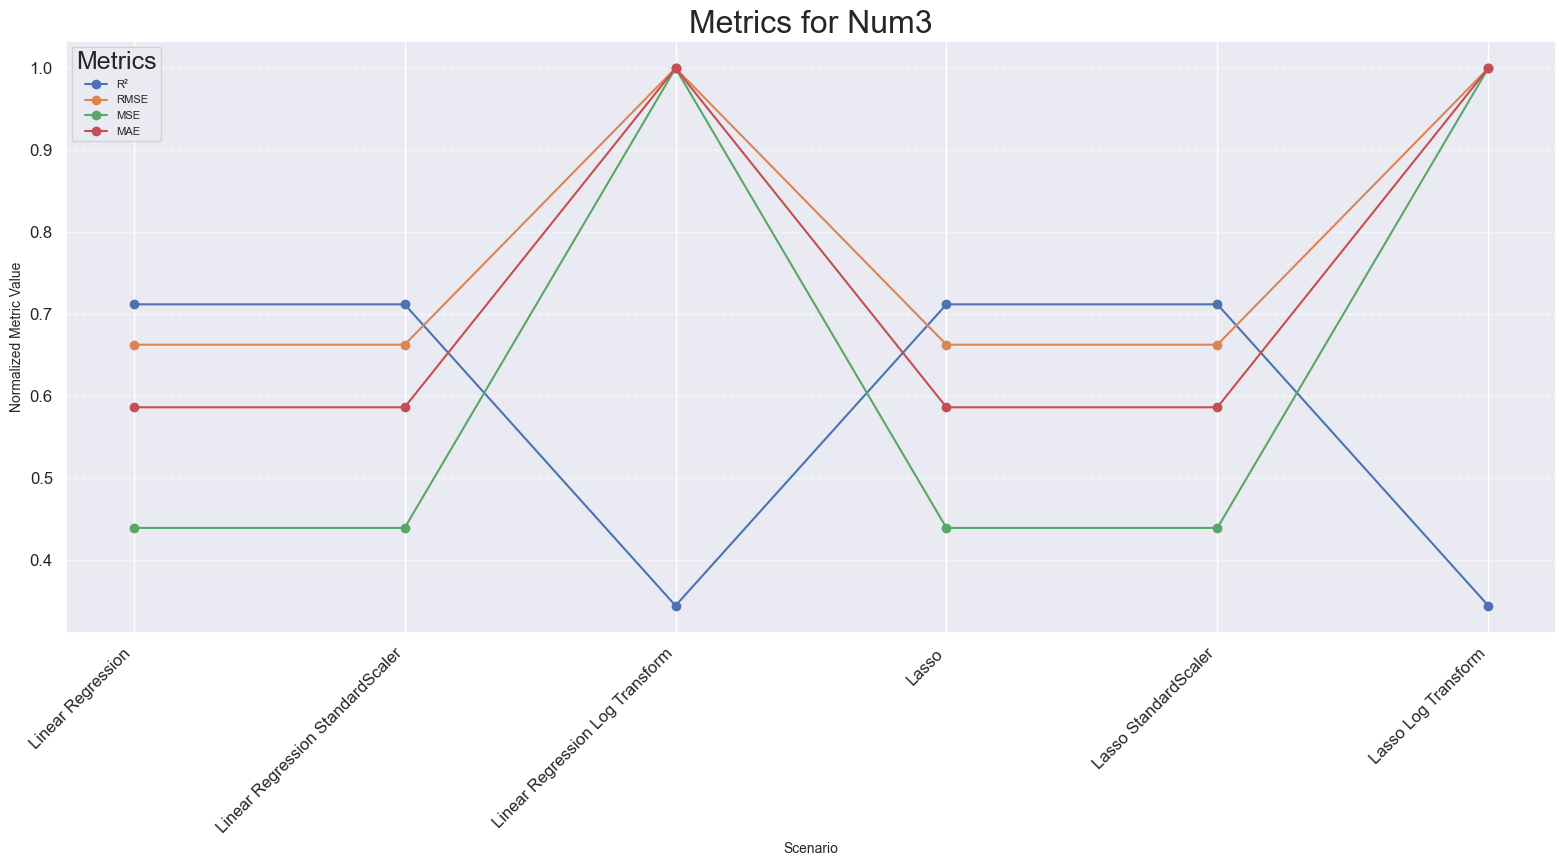

In [ ]:
# normalize the data
df_normalized = LG_results_df3.copy()
for col in ["RMSE", "MSE", "MAE"]:
    df_normalized[col] = LG_results_df3[col] / LG_results_df3[col].max()

# Plot line graph
plt.figure(figsize=(16, 9))
for column in df_normalized.columns:
    plt.plot(df_normalized.index, df_normalized[column], marker='o', label=column)

#  titles and labels
plt.title("Metrics for Num3", fontsize=23)
plt.ylabel("Normalized Metric Value", fontsize=10)
plt.xlabel("Scenario", fontsize=10)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle="--", alpha=0.7)
plt.legend(title="Metrics", fontsize=8)
plt.tight_layout()

# Show plot
plt.show()